In [1]:
import cpa
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/home/icb/yuge.ji/.local/lib/python3.7/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/icb/yuge.ji/miniconda3/envs/py37_cpa/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
import scanpy as sc
sc.set_figure_params(dpi=300, frameon=False, color_map='Reds')


# Training your model

In [3]:
adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/test_AdvAE/datasets/lincs.h5ad')
adata.obs['dose_val'] = adata.obs.pert_dose.values/max(adata.obs.pert_dose.unique())
adata

AnnData object with n_obs × n_vars = 199620 × 978
    obs: 'cell_id', 'det_plate', 'det_well', 'lincs_phase', 'pert_dose', 'pert_dose_unit', 'pert_id', 'pert_iname', 'pert_mfc_id', 'pert_time', 'pert_time_unit', 'pert_type', 'rna_plate', 'rna_well', 'batch', 'condition', 'cell_type', 'dose_val', 'cov_drug_dose_name', 'control', 'split'
    var: 'pr_gene_title', 'pr_is_lm', 'pr_is_bing'
    uns: 'rank_genes_groups_cov'

### Init your model

In [4]:
# load previous model
cpa_api = cpa.api.API(
    adata,
    pretrained='/storage/groups/ml01/workspace/carlo.dedonno/cpa-reproducibility/notebooks/lincs_model_2.pt'
)

Loaded pretrained model from:	/storage/groups/ml01/workspace/carlo.dedonno/cpa-reproducibility/notebooks/lincs_model_2.pt


In [5]:
# generate new model
cpa_api = cpa.api.API(
    adata, 
    perturbation_key='condition',
    split_key='split',
    covariate_keys=['cell_type'],
    dose_key='dose_val',
    doser_type='logsigm',
    only_parameters=False,
    hparams={
        'adversary_reg': 50,
        'autoencoder_depth': 2,
        'dosers_depth': 1,
        'dim': 50
    },
    control='control'
)

In [6]:
cpa_api.model.hparams

{'dim': 50,
 'dosers_width': 128,
 'dosers_depth': 1,
 'dosers_lr': 0.004,
 'dosers_wd': 1e-07,
 'autoencoder_width': 128,
 'autoencoder_depth': 2,
 'adversary_width': 64,
 'adversary_depth': 2,
 'reg_adversary': 60,
 'penalty_adversary': 60,
 'autoencoder_lr': 0.0003,
 'adversary_lr': 0.0003,
 'autoencoder_wd': 4e-07,
 'adversary_wd': 4e-07,
 'adversary_steps': 3,
 'batch_size': 256,
 'step_size_lr': 45,
 'adversary_reg': 50}

In [7]:
cpa_api.model

CPA(
  (encoder): MLP(
    (network): Sequential(
      (0): Linear(in_features=978, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=50, bias=True)
    )
  )
  (decoder): MLP(
    (network): Sequential(
      (0): Linear(in_features=50, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=1956, bias=True)
    )
  )
  (adversary_drugs): MLP(
    (network): Sequential(
      (0)

### Start training

In [8]:
import torch
cpa_api.train(max_epochs=5*100, run_eval=True, checkpoint_freq=5, max_minutes=480, save_dir='/home/icb/yuge.ji/projects/CPA/pretrained_models/lincs/')

Results will be saved to the folder: /home/icb/yuge.ji/projects/CPA/pretrained_models/lincs/


Rec: 0.3179, AdvPert: 0.01, AdvCov: 3.15: 100%|▉| 499/500 [3:39:14<00:26, 26.36s

Model saved to: /home/icb/yuge.ji/projects/CPA/pretrained_models/lincs/model.pt
{'ellapsed_minutes': 217.3209478855133,
 'epoch': 499,
 'evaluation_stats': {'cell_type disentanglement': 0.004581571090966463,
                      'ood': [0.8946292962190441,
                              0.5839533080352479,
                              0.23781508260030917,
                              0.25105428545373415],
                      'optimal for cell_type': 0.012195121951219513,
                      'optimal for perturbations': 0.000999000999000999,
                      'perturbation disentanglement': 0.0005446622963063419,
                      'test': [0.8921930041298042,
                               0.6002136805125771,
                               0.1552404713512523,
                               0.2323711182540088],
                      'training': [0.9391701663301641,
                                   0.8144828501127621,
                                   0.28008560624377904,

Model saved to: /home/icb/yuge.ji/projects/CPA/pretrained_models/lincs/model.pt


Computation time: 217 min


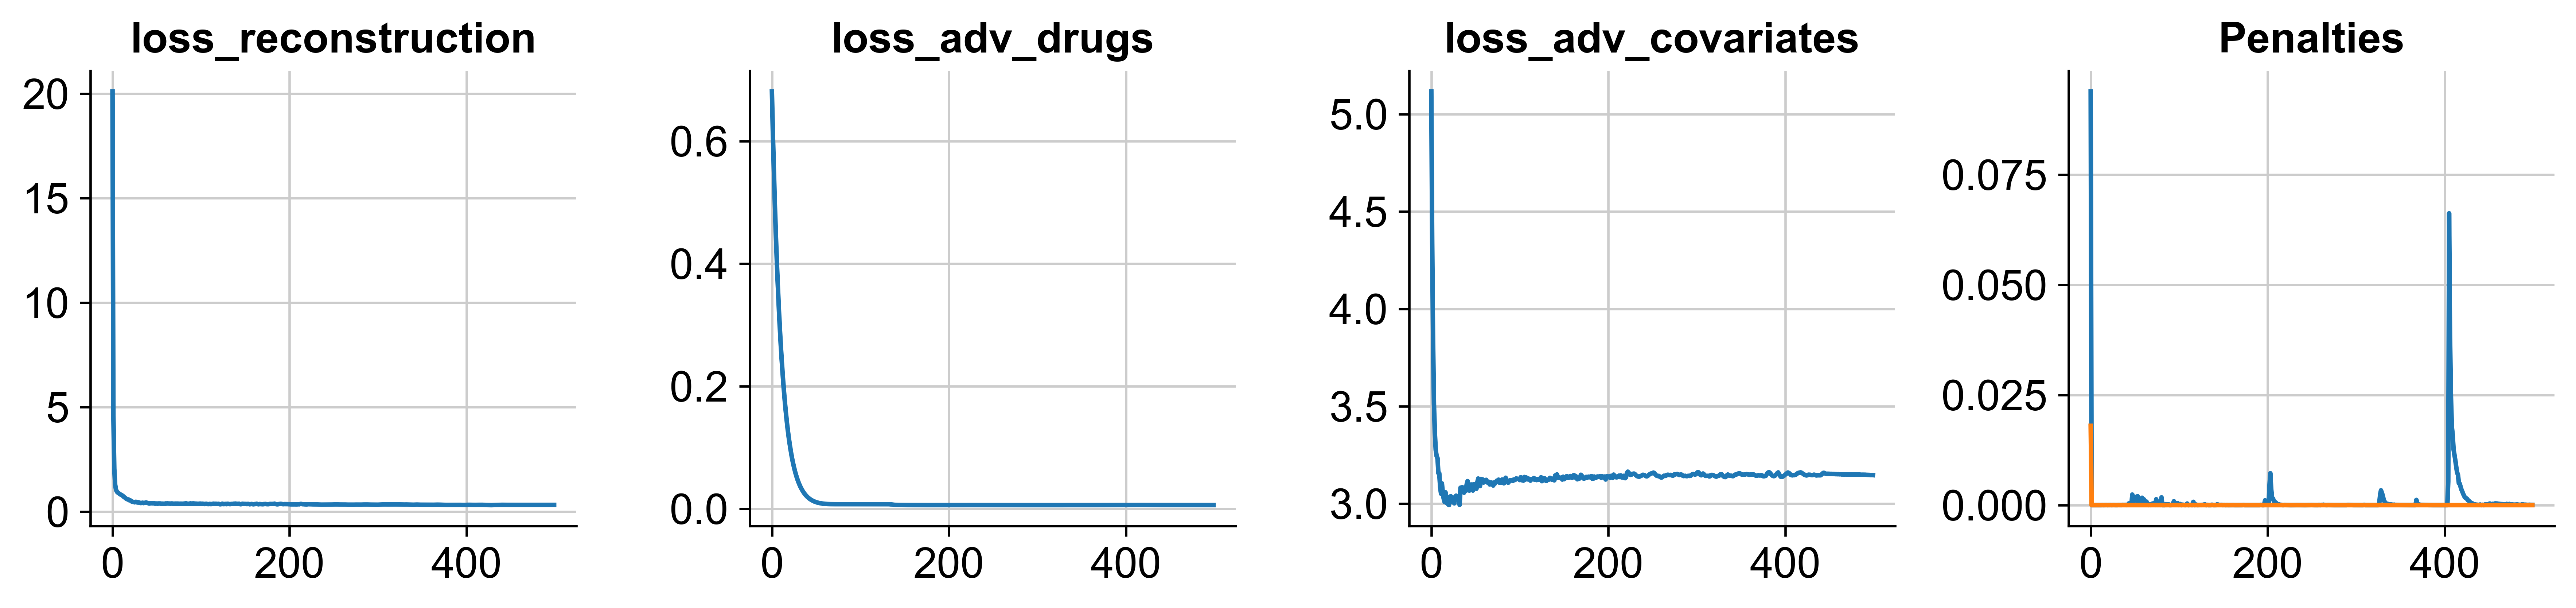

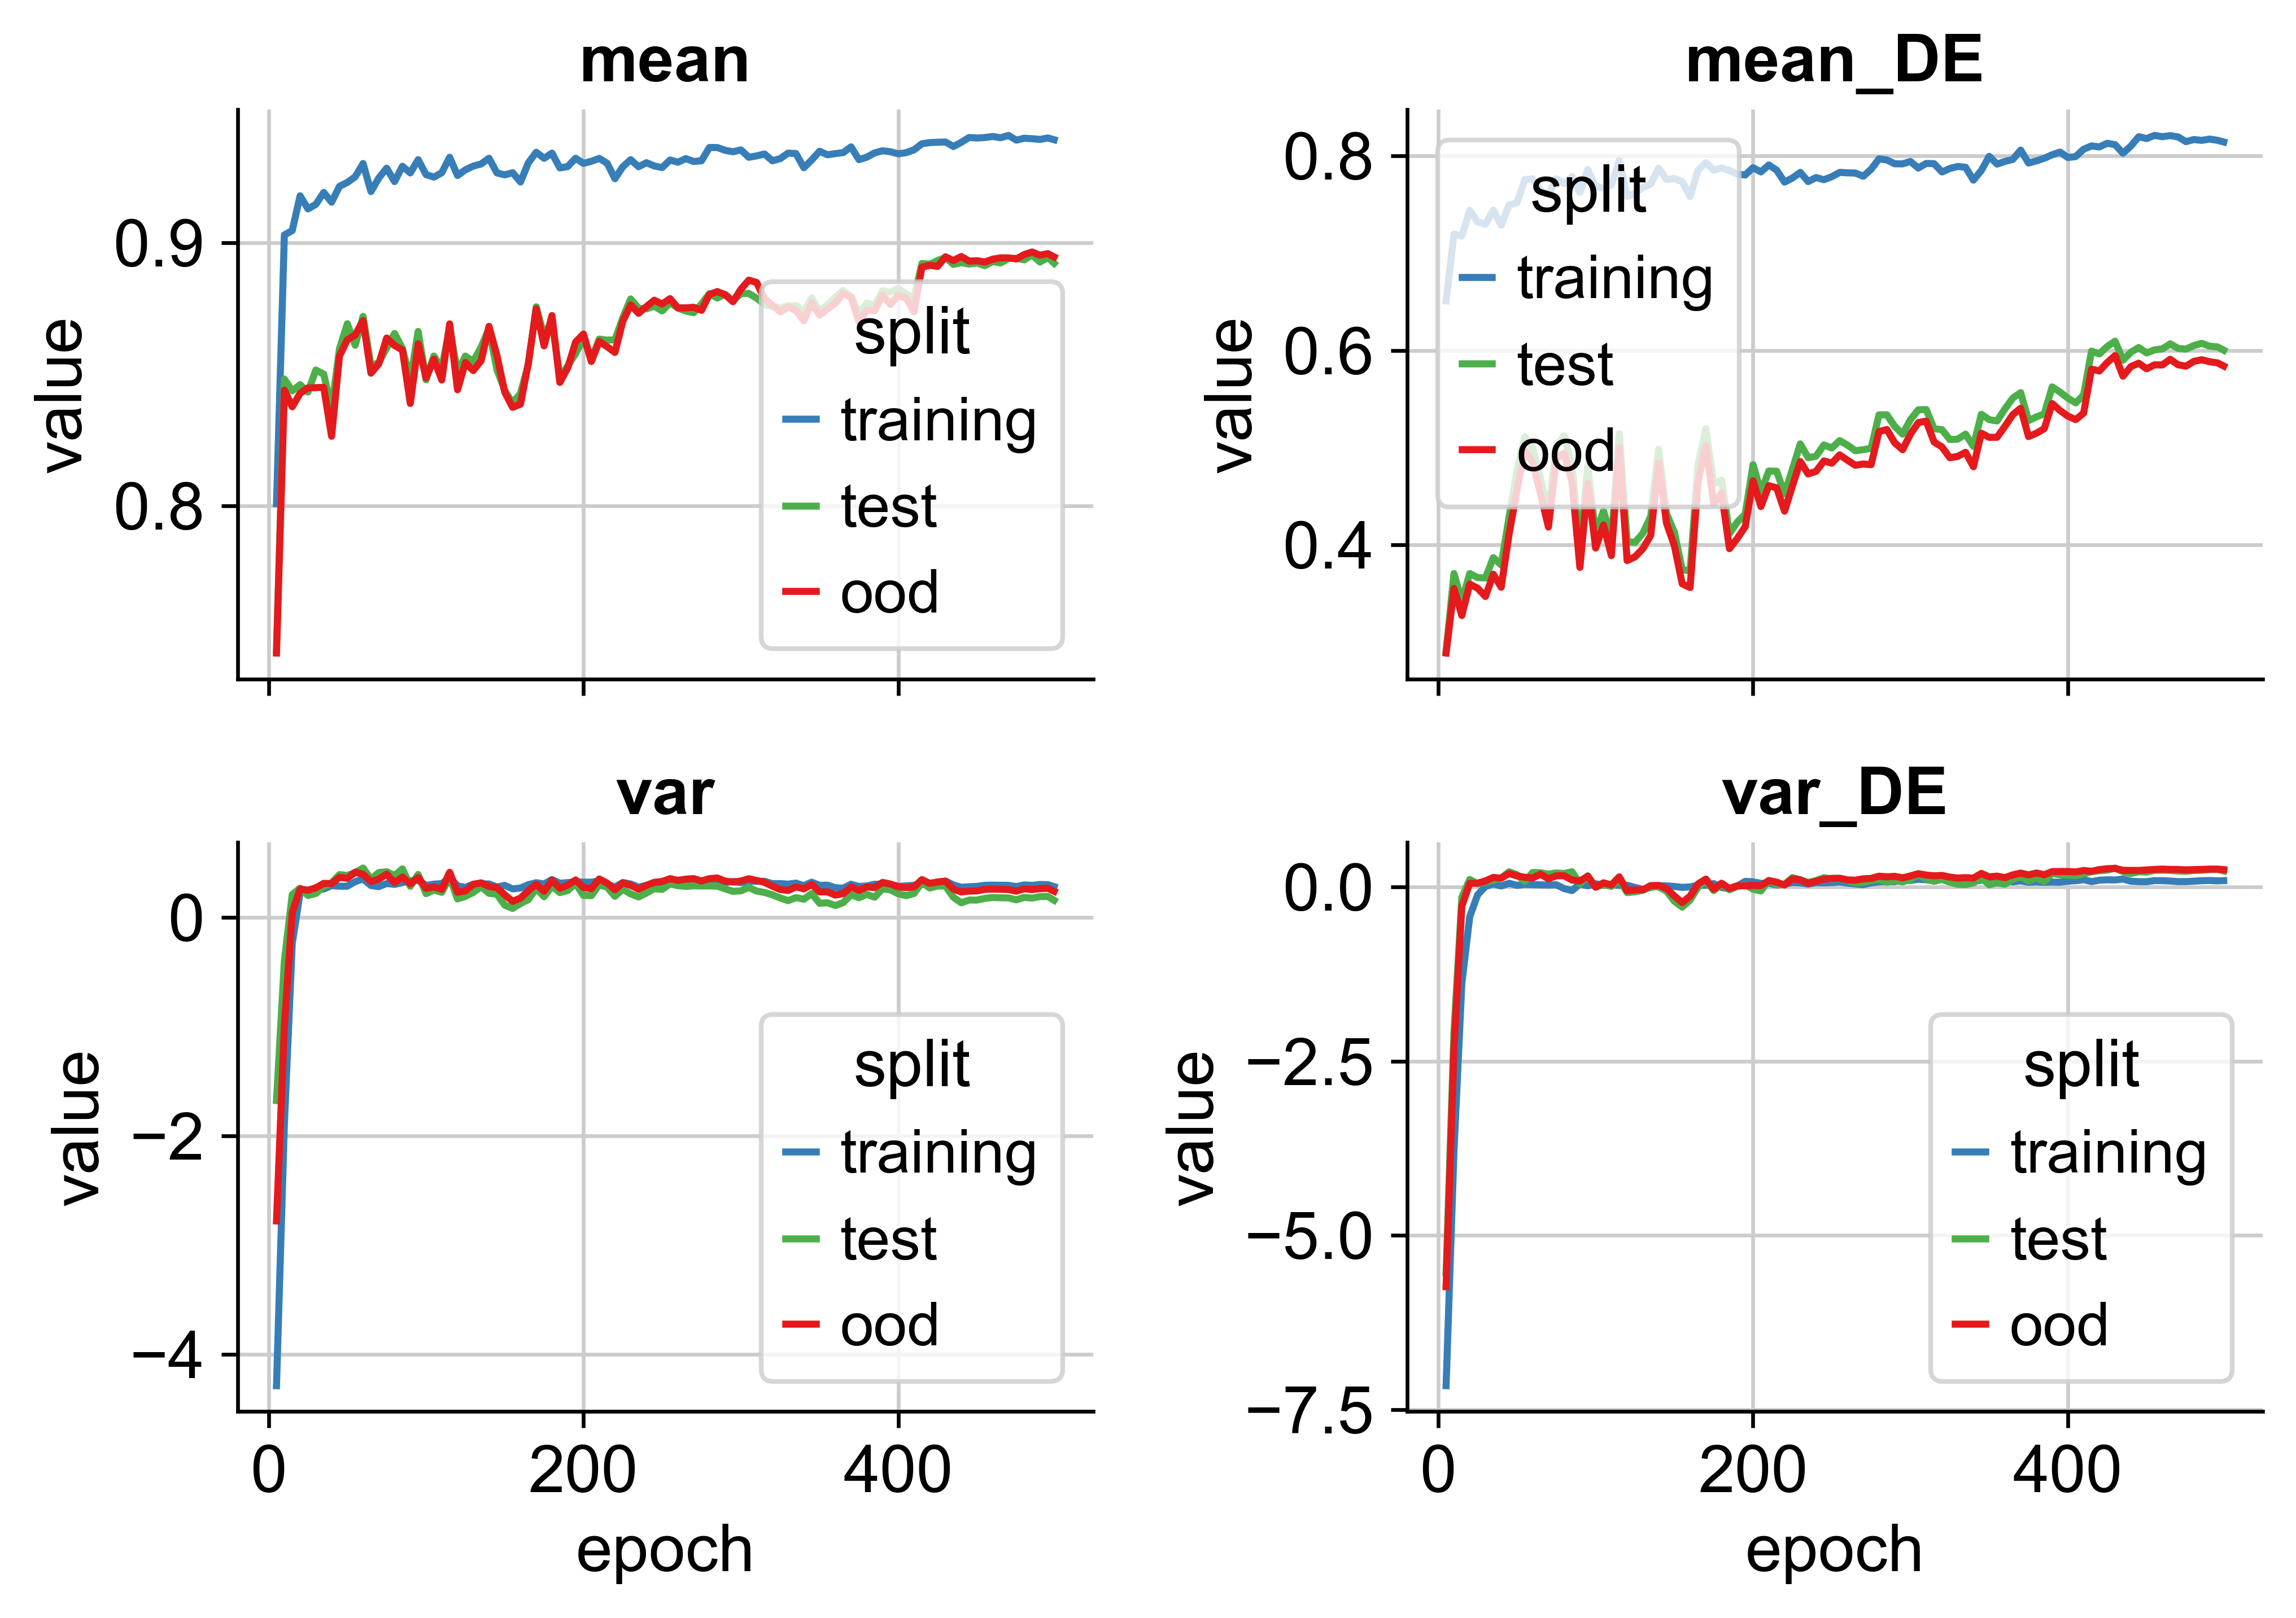

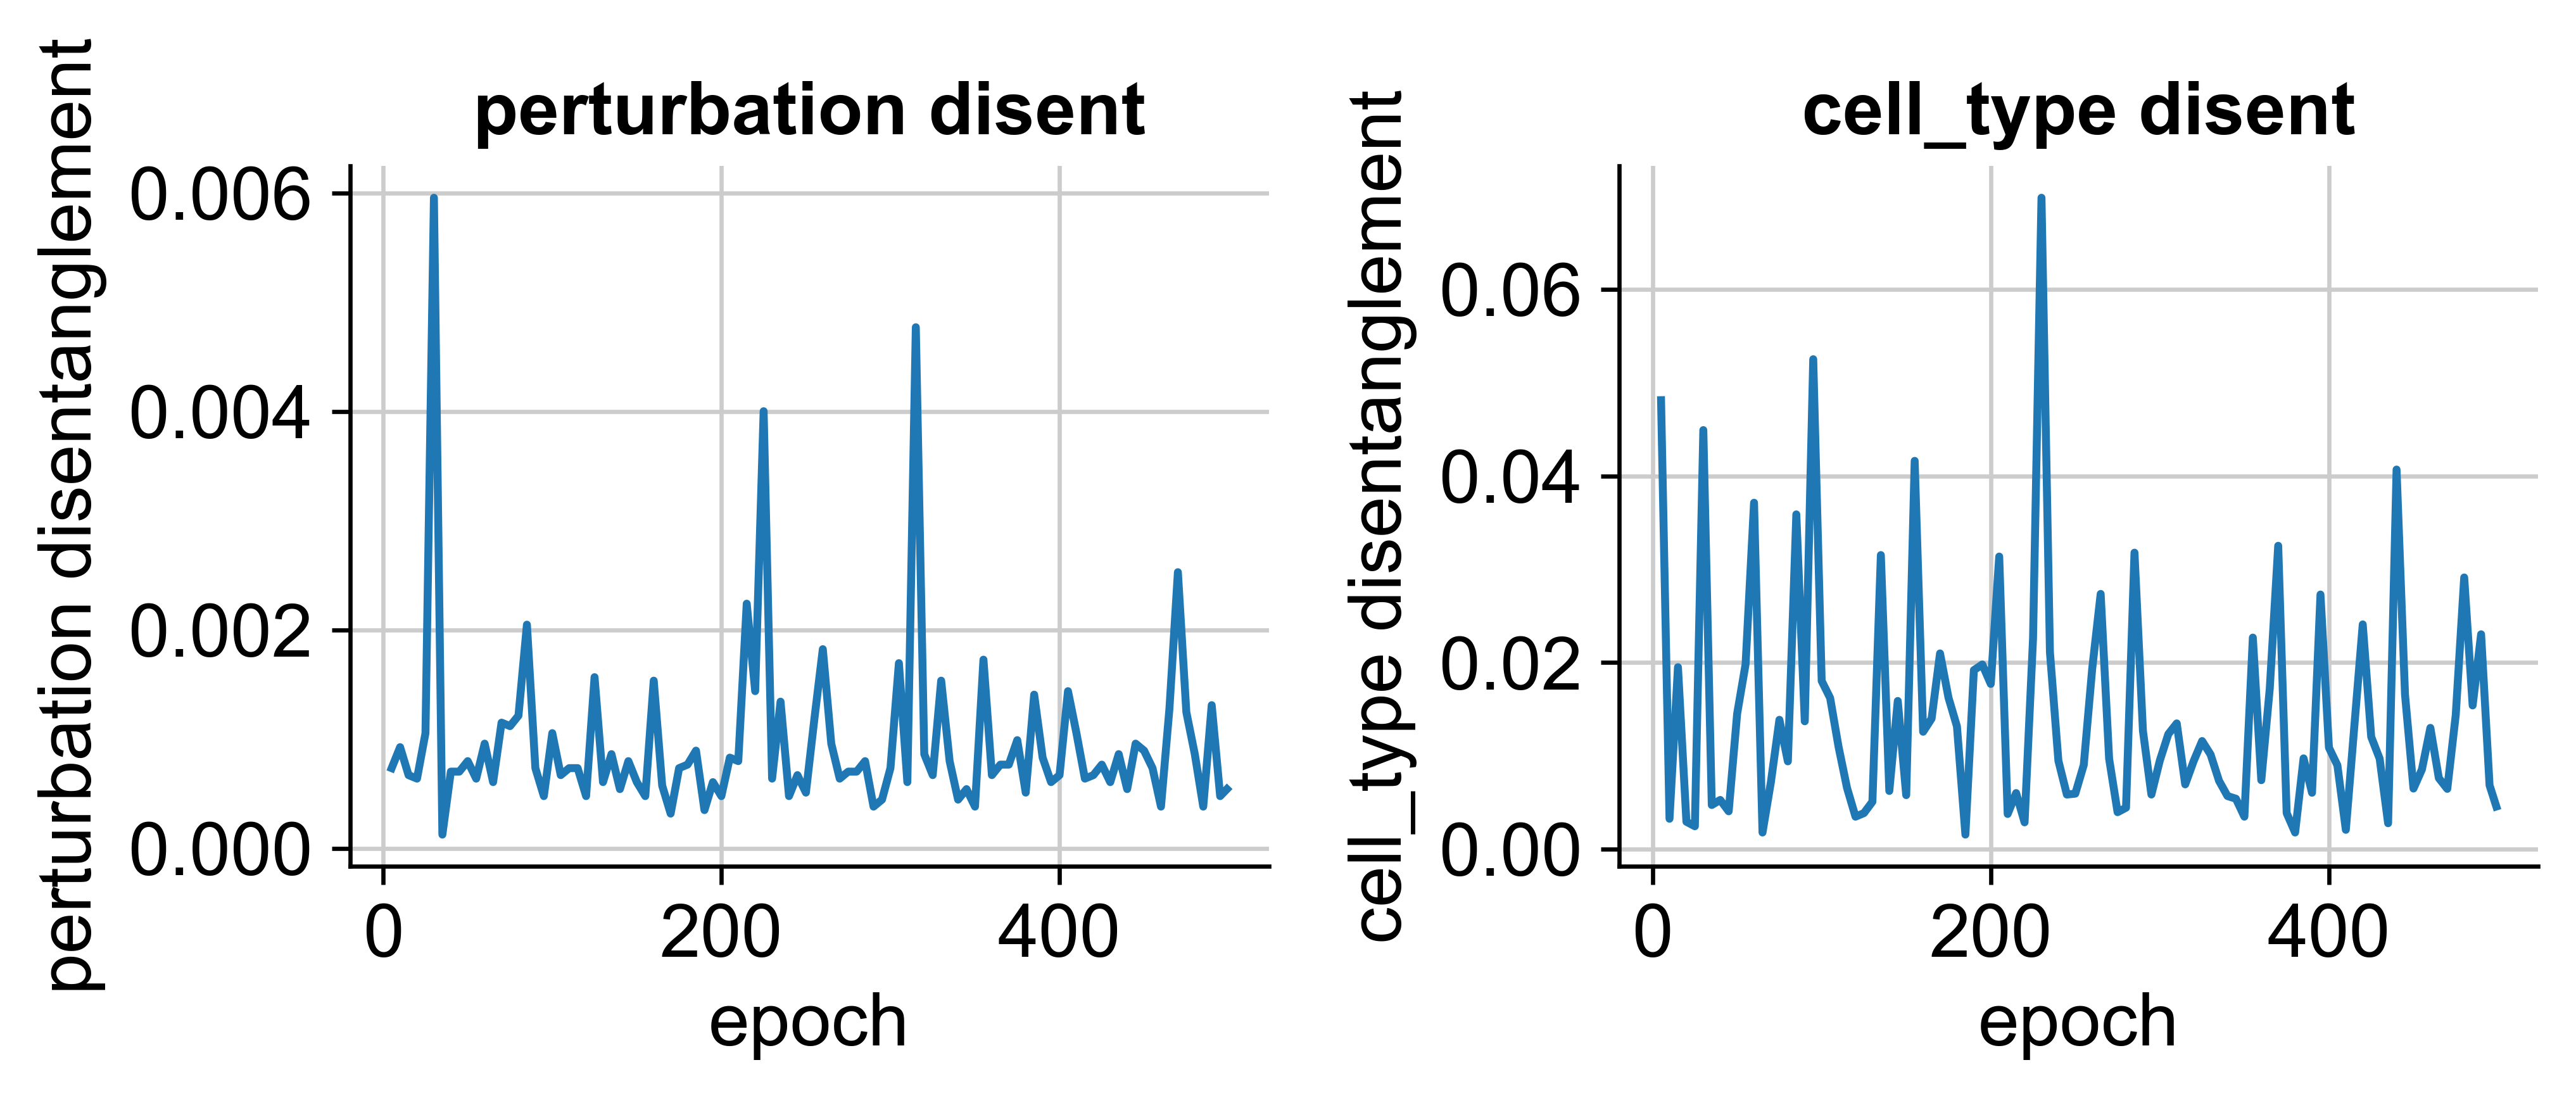

In [9]:
from cpa.plotting import CPAHistory
pretty_history = CPAHistory(cpa_api)
pretty_history.print_time()
pretty_history.plot_losses()
pretty_history.plot_r2_metrics(epoch_min=0)
pretty_history.plot_disentanglement_metrics(epoch_min=0)

### Visualize embeddings

In [6]:
sciplex = sc.read('/home/icb/carlo.dedonno/projects/cpa-reproducibility/datasets/sciplex3_old_reproduced.h5ad')

In [8]:
# pathway_color_dict = {'Antioxidant': '#1f77b4',
#  'Apoptotic regulation': '#ff7f0e',
#  'Cell cycle regulation': '#279e68',
#  'DNA damage & DNA repair': '#d62728',
#  'Epigenetic regulation': '#aa40fc',
#  'Focal adhesion signaling': '#8c564b',
#  'HIF signaling': '#e377c2',
#  'JAK/STAT signaling': '#b5bd61',
#  'Metabolic regulation': '#17becf',
#  'Neuronal signaling': '#aec7e8',
#  'Nuclear receptor signaling': '#ffbb78',
#  'Other': '#98df8a',
#  'PKC signaling': '#ff9896',
#  'Protein folding & Protein degradation': '#c5b0d5',
#  'TGF/BMP signaling': '#c49c94',
#  'Tyrosine kinase signaling': '#f7b6d2',
#  'Vehicle': '#dbdb8d'}

In [5]:
perts_anndata = cpa_api.get_drug_embeddings()
perts_anndata

AnnData object with n_obs × n_vars = 1001 × 25
    obs: 'condition'

Add MoA labels.

In [11]:
perts_anndata.obs['pathway_level_1'] = perts_anndata.obs['condition'].map(dict(zip(sciplex.obs.condition.astype(str).str.lower().values, sciplex.obs.pathway_level_1.values))).astype('category')
perts_anndata.obs['pathway_level_2'] = perts_anndata.obs['condition'].map(dict(zip(sciplex.obs.condition.astype(str).str.lower().values, sciplex.obs.pathway_level_2.values))).astype('category')

Plot latent space structure.

In [24]:
sc.pp.pca(perts_anndata)
sc.pp.neighbors(perts_anndata, metric='cosine', n_neighbors=5)
sc.tl.umap(perts_anndata)

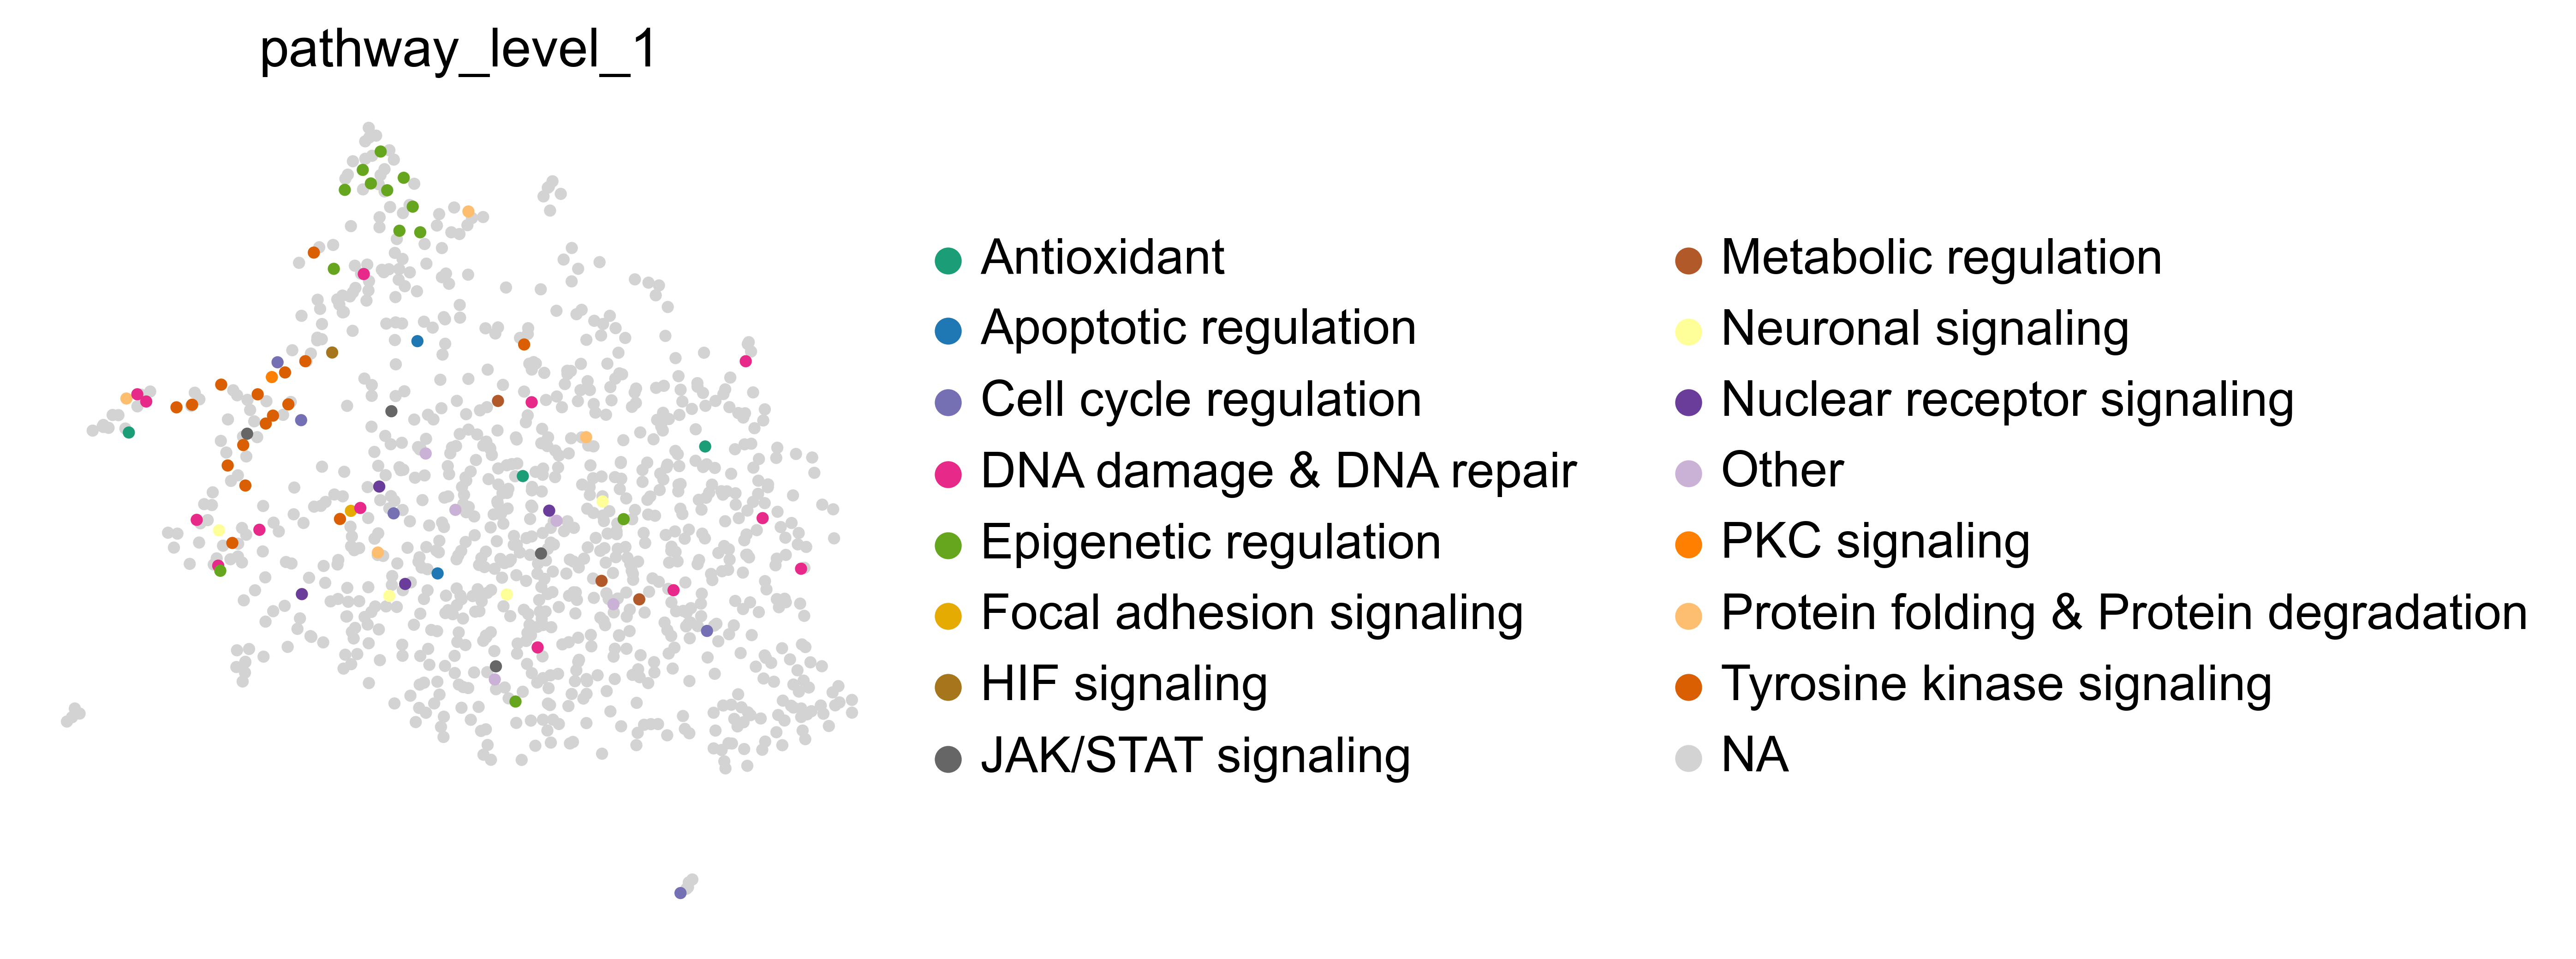

In [25]:
import seaborn as sns
c_list = sns.color_palette('Dark2').as_hex() + sns.color_palette('Paired').as_hex()[::-1]
color_dict = dict(zip(perts_anndata.obs['pathway_level_1'].cat.categories, c_list))
color_dict['Tyrosine kinase signaling'] = '#d95f02'  # switch these two
color_dict['Apoptotic regulation'] = '#1f78b4'
color_dict['Vehicle'] = '#000000'
sc.pl.umap(perts_anndata, color='pathway_level_1', palette=color_dict, size=40)

Figure 3j latent space plot.

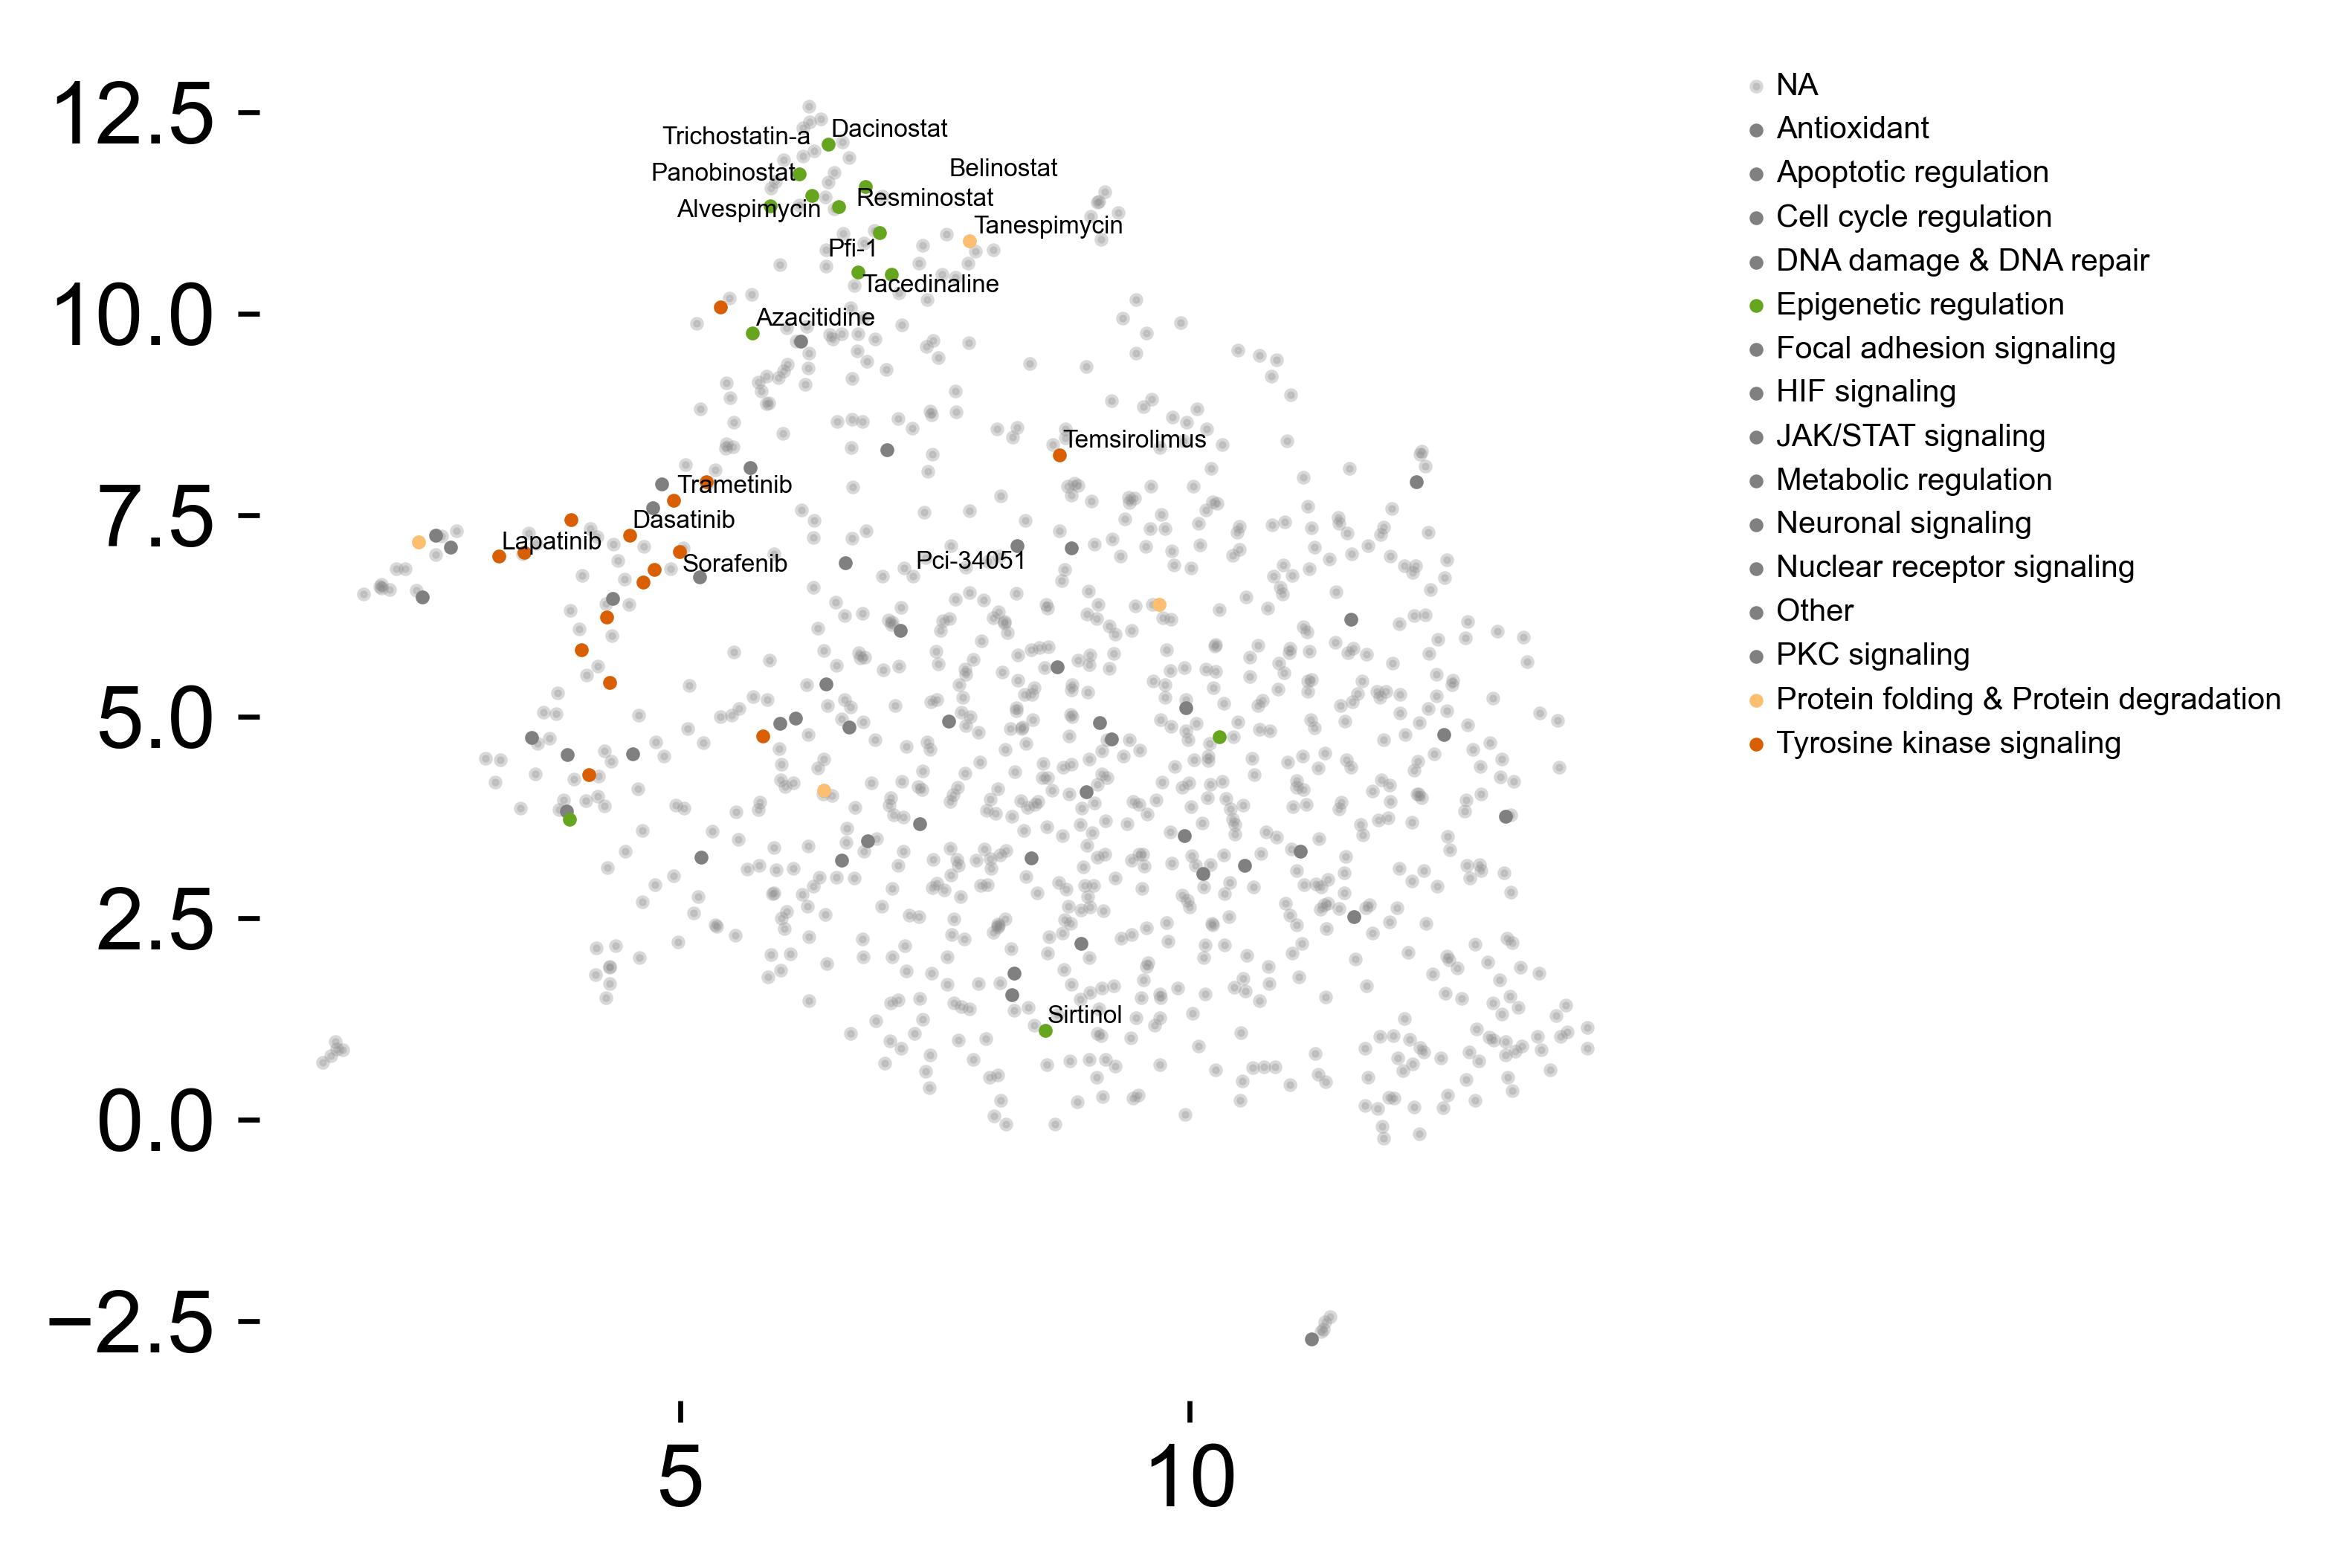

In [34]:
from adjustText import adjust_text

cmpds = [
    # epigenetic
    'dacinostat', 'UNC0379', 'pracinostat', 'UNC1999', 'sirtinol',
    'TMP195', 'GSK', 'PCI-34051', 'tacedinaline',
    'EED226', 'tucidinostat', 'PFI-1', 'CUDC-907', 'selisistat',
    'anacardic', 'azacitidine', 'AR-42', 'belinostat',
    'tazemetostat', 'SRT3025', 'trichostatin-a', 'SRT1720', 'panobinostat', 'UNC0631',
    'A-366', 'divalproex', 'resminostat',
    # vehicle
    'Vehicle',
    # tyrosine kinase
    'lapatinib', 'sorafenib', 'dasatinib', 'trametinib', 'temsirolimus',
    # protein
    'luminespib', 'tanespimycin', 'alvespimycin']

# plot all points in grey first
x = perts_anndata.obsm['X_umap'].T[0]
y = perts_anndata.obsm['X_umap'].T[1]
plt.scatter(x, y, label='NA', color='grey', s=1.5, alpha=.3)
for i, moa in enumerate(perts_anndata.obs.pathway_level_1.cat.categories):
    if moa in ['Epigenetic regulation', 'Tyrosine kinase signaling', 'Protein folding & Protein degradation']:
        color = perts_anndata.uns['pathway_level_1_colors'][i]
    else:
        color = 'grey'
    subset = perts_anndata[perts_anndata.obs.pathway_level_1 == moa].copy()
    x = subset.obsm['X_umap'].T[0]
    y = subset.obsm['X_umap'].T[1]
    plt.scatter(x, y, label=moa, color=color, s=1.5)
    
# plot texts
x = perts_anndata.obsm['X_umap'].T[0]
y = perts_anndata.obsm['X_umap'].T[1]
texts = [plt.text(x[i], y[i], f'{perts_anndata.obs.condition.values[i]}'.capitalize(), size=4) for i in range(len(x)) if perts_anndata.obs.condition.values[i] in cmpds]
adjust_text(texts)
plt.grid(b=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5, frameon=False)
# plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
plt.box(False)
plt.show();

#### cell-type embedding

In [16]:
covars_anndata = cpa_api.get_covars_embeddings('cell_type')
covars_anndata

AnnData object with n_obs × n_vars = 82 × 25
    obs: 'cell_type'

In [23]:
sc.pp.pca(covars_anndata)
sc.pp.neighbors(covars_anndata, metric='cosine', n_neighbors=5)
sc.tl.umap(covars_anndata)

Cell line annotations (as standardized by CCLE).

In [27]:
cldf = pd.read_csv('/home/icb/yuge.ji/projects/sc-pert/CCLE/sample_info.csv')

# add annotation
covars_anndata.obs['lineage'] = covars_anndata.obs.cell_type.map(dict(zip(cldf['stripped_cell_line_name'].values, cldf['lineage'].values)))

Remaining cell lines are not in CCLE because they are not cancer cell lines.

In [28]:
len(set(covars_anndata.obs.cell_type.unique()) - set(cldf['stripped_cell_line_name'].unique()))

22

... storing 'lineage' as categorical


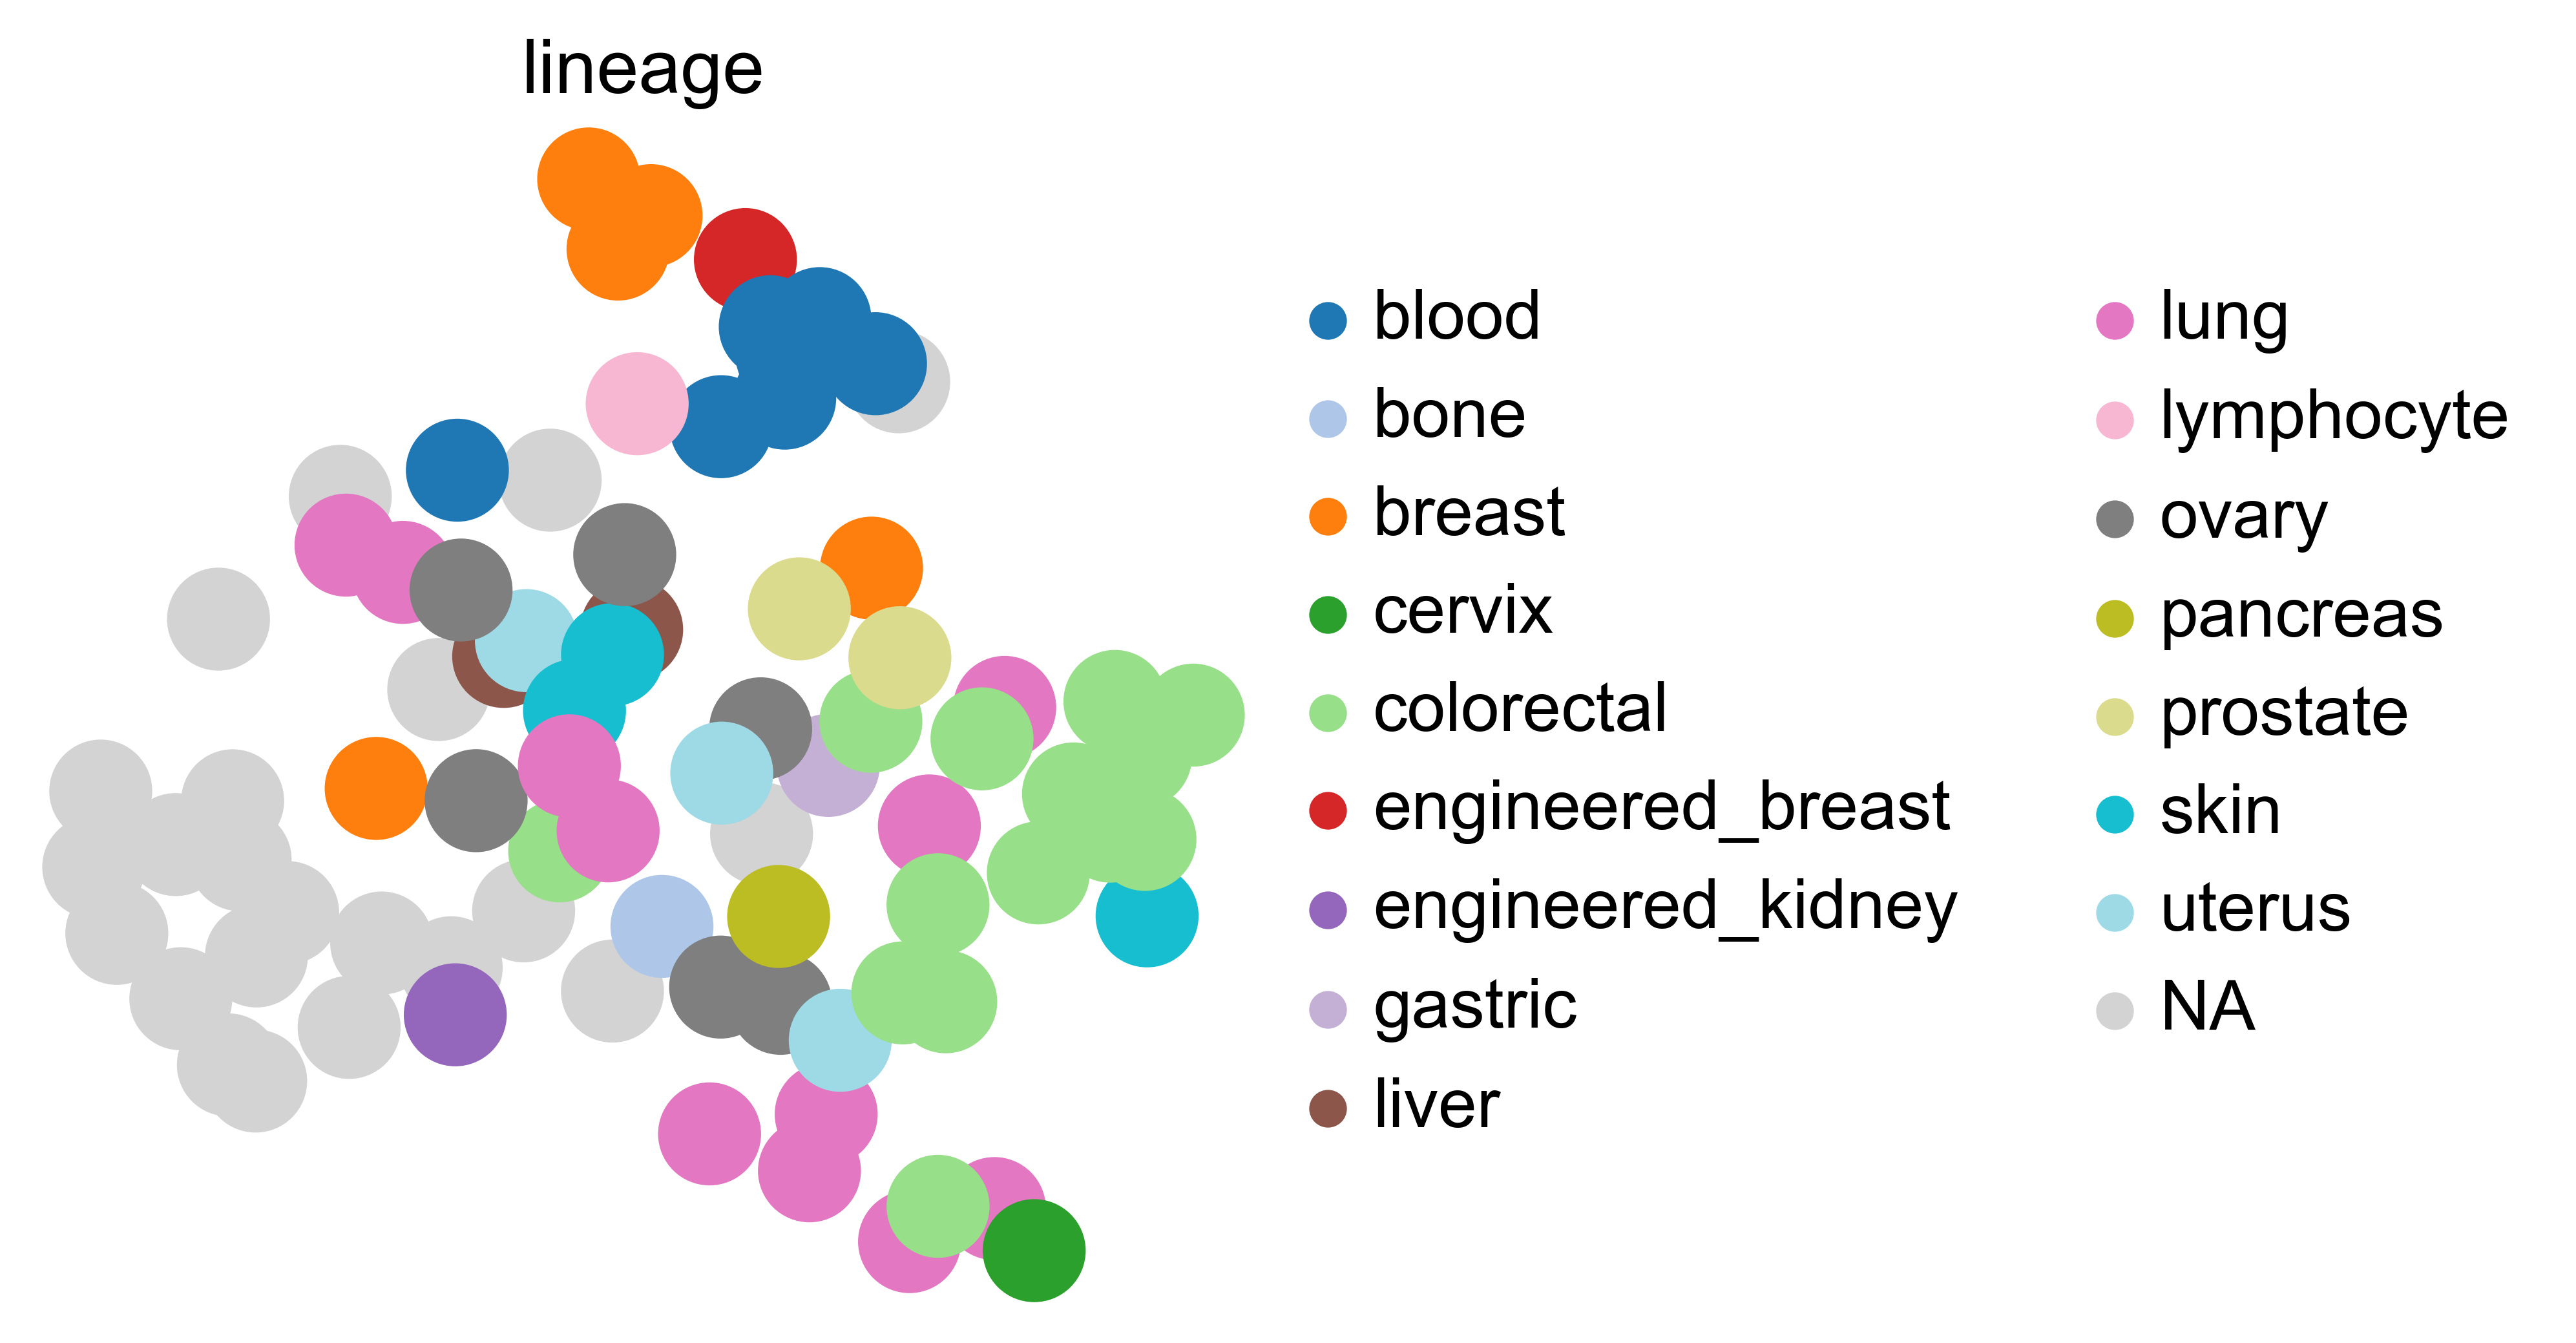

In [29]:
sc.pl.umap(covars_anndata, color='lineage', palette='tab20')

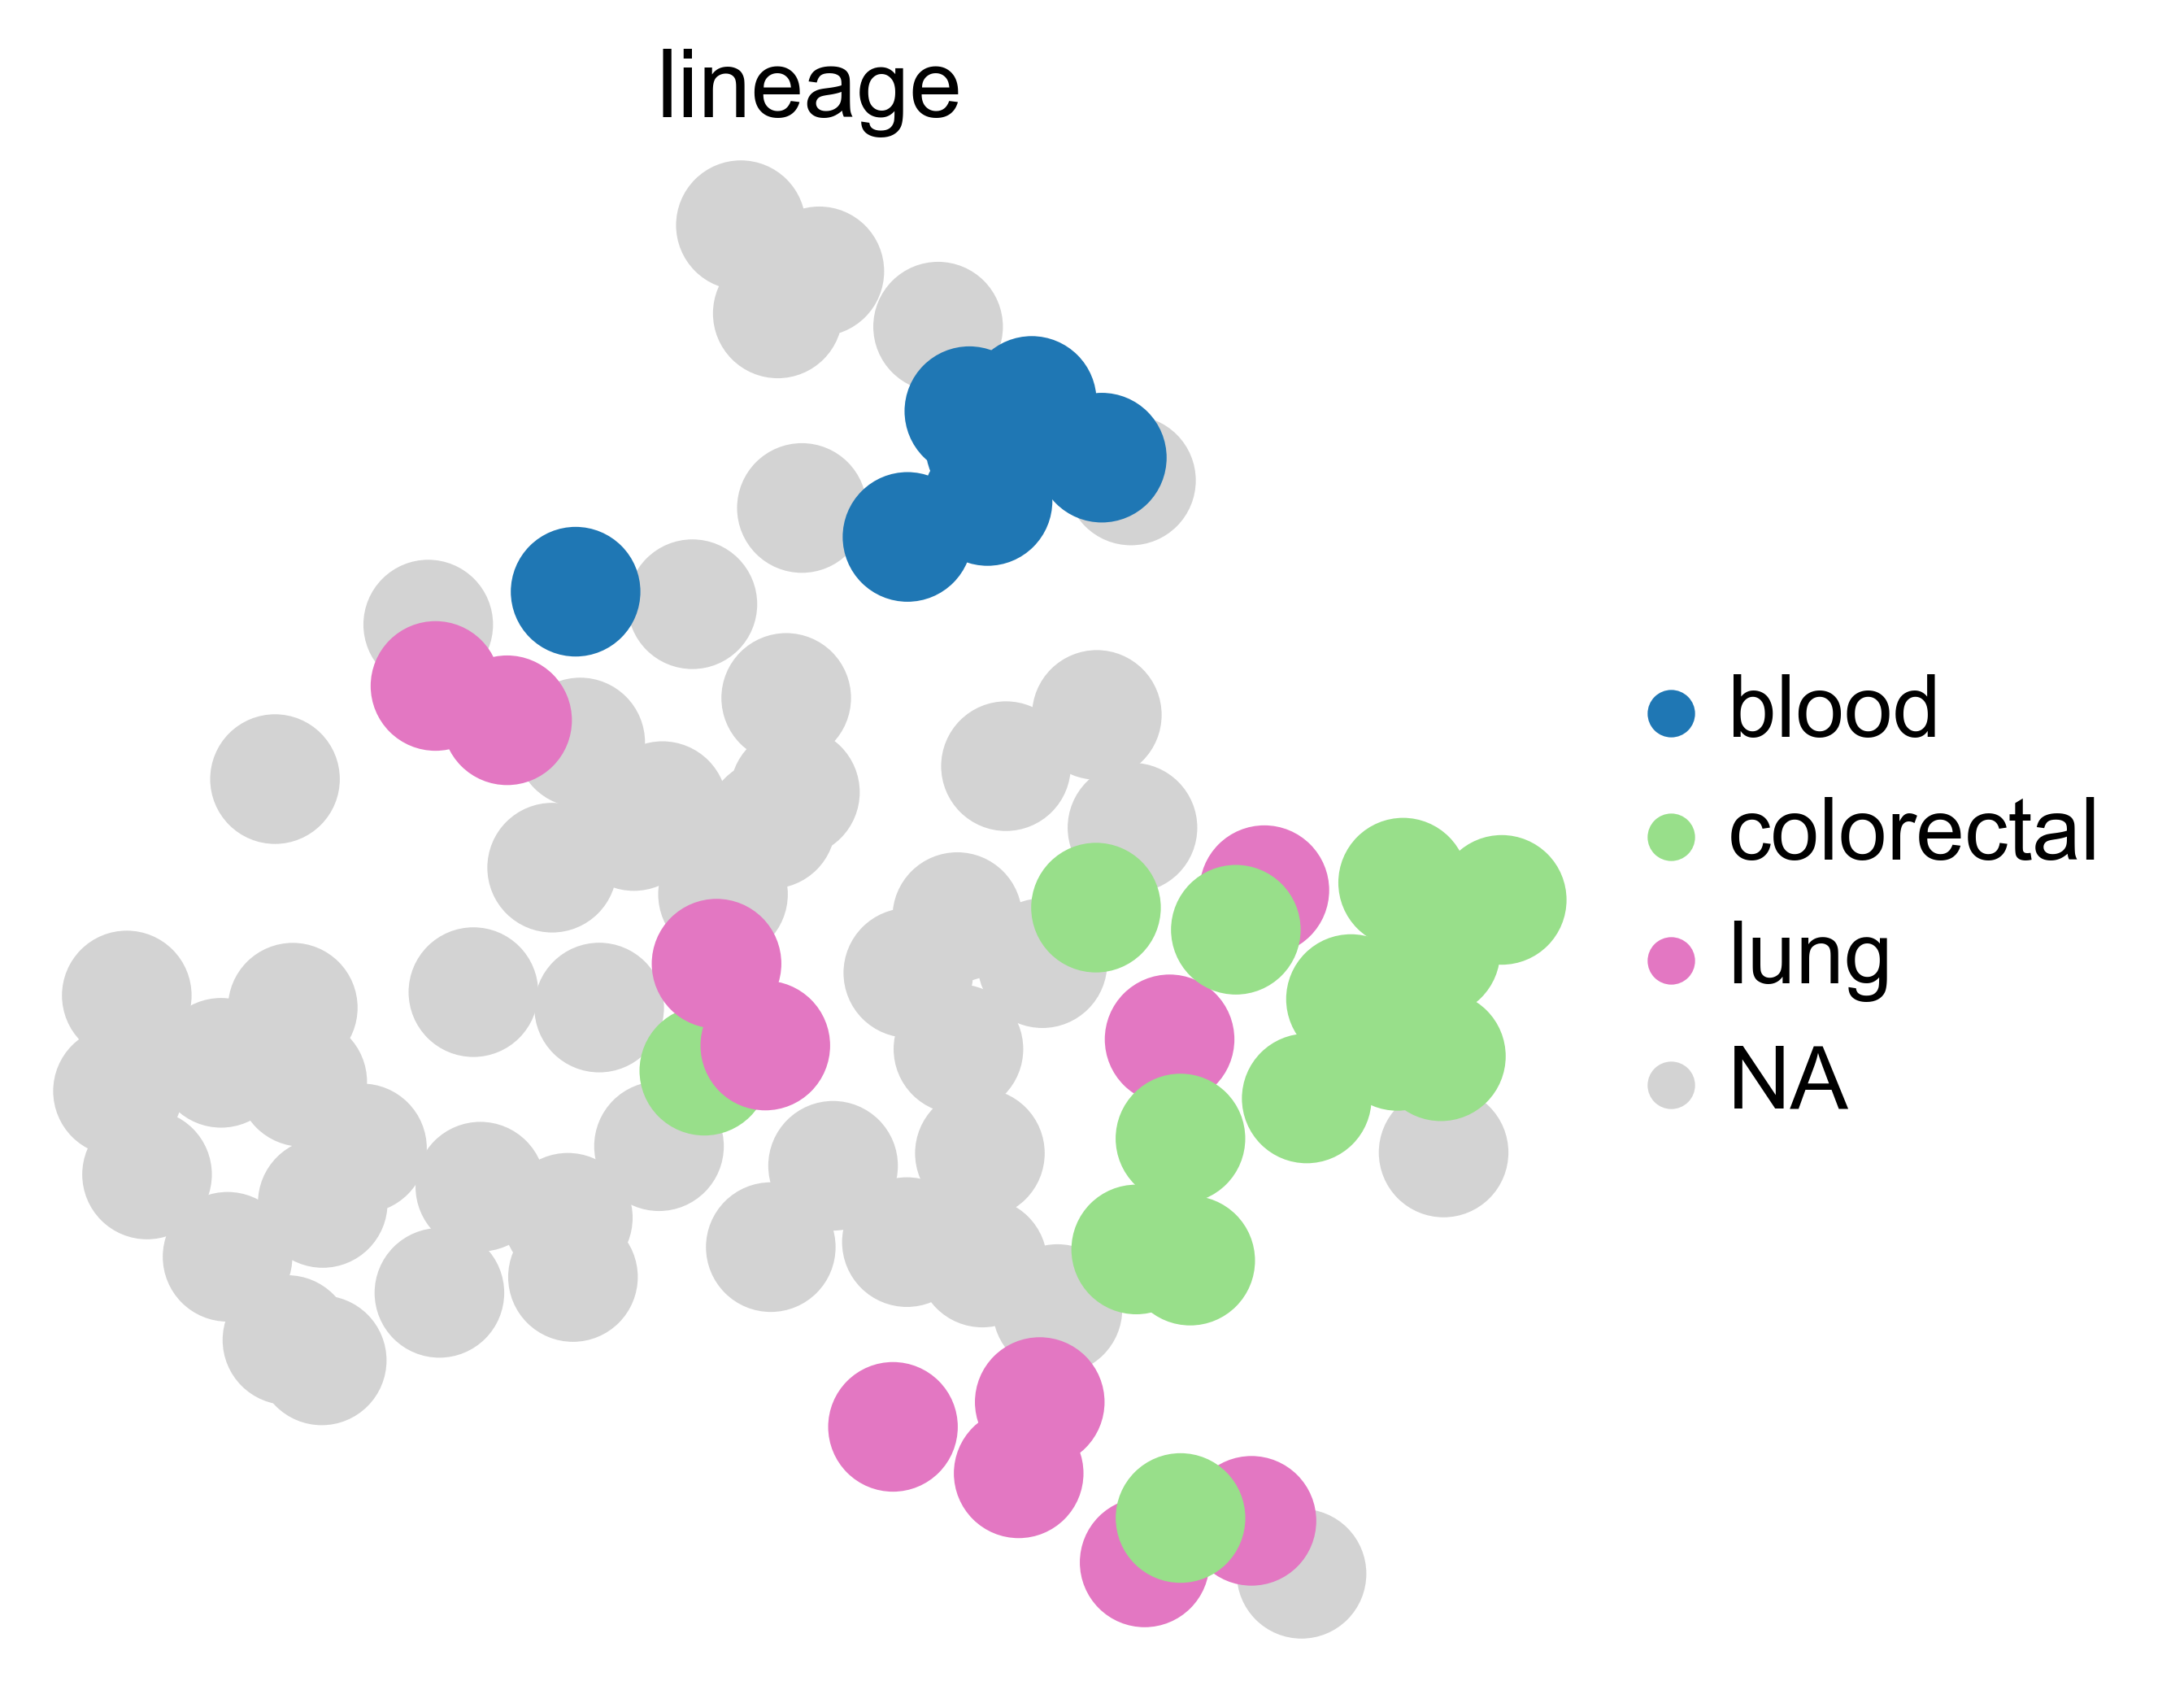

In [30]:
sc.pl.umap(covars_anndata, color='lineage', groups=['blood', 'colorectal', 'lung'])

Figure 3h.

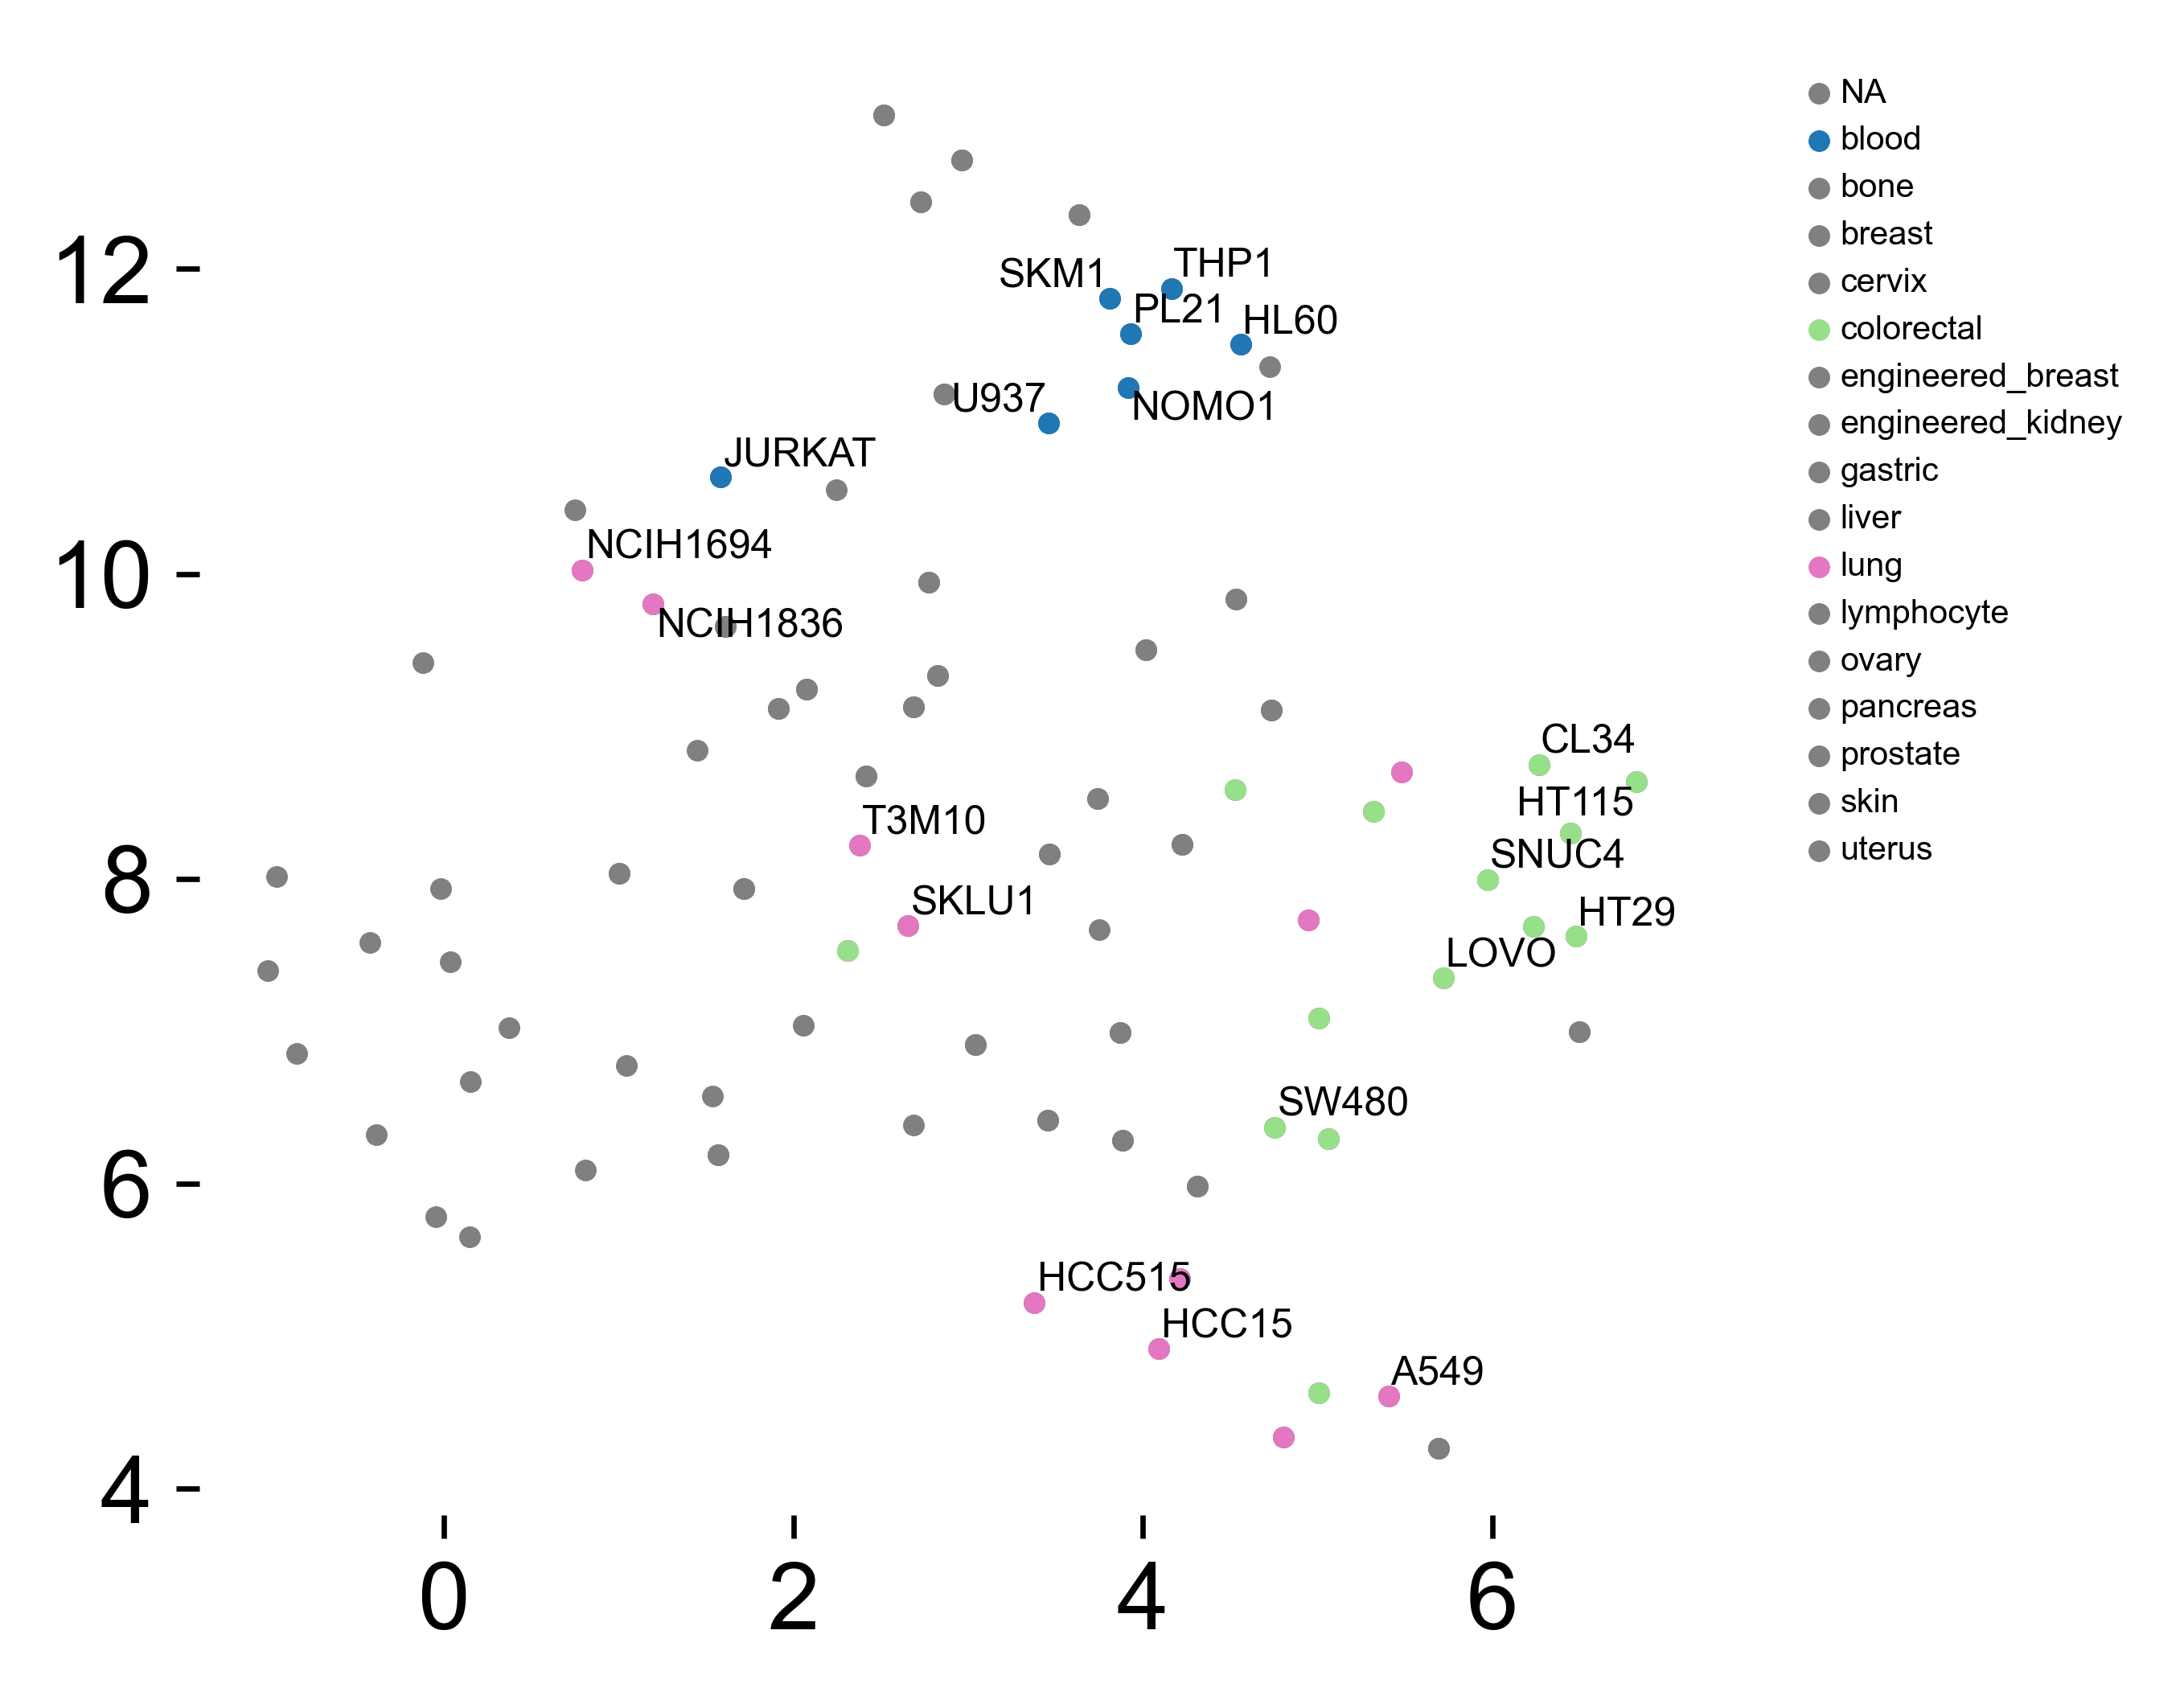

In [31]:
cls = [
    # lung
    'HL60', 'SKM1', 'JURKAT', 'U937', 'PL21', 'THP1', 'NOMO1',
    # colorectal
    'LOVO', 'SW480', 'SNUC4', 'HT29', 'CL34', 'HT115',
    # lung
    'A549', 'T3M10', 'HCC15', 'HCC515', 'NCIH1694', 'NCIH1836', 'SKLU1']

x = covars_anndata.obsm['X_umap'].T[0]
y = covars_anndata.obsm['X_umap'].T[1]
plt.scatter(x, y, label='NA', color='grey', s=5)
for i, source in enumerate(covars_anndata.obs.lineage.cat.categories):
    if source in ['blood', 'colorectal', 'lung']:
        color = covars_anndata.uns['lineage_colors'][i]
    else:
        color = 'grey'
    subset = covars_anndata[covars_anndata.obs.lineage == source].copy()
    x = subset.obsm['X_umap'].T[0]
    y = subset.obsm['X_umap'].T[1]
    plt.scatter(x, y, label=source, color=color, s=5)
    
# plot texts
x = covars_anndata.obsm['X_umap'].T[0]
y = covars_anndata.obsm['X_umap'].T[1]
texts = [plt.text(x[i], y[i], f'{covars_anndata.obs.cell_type.values[i]}', size=6) for i in range(len(x)) if covars_anndata.obs.cell_type.values[i] in cls]
adjust_text(texts)
plt.grid(b=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5, frameon=False)
# plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
plt.box(False)
plt.show();